<a href="https://colab.research.google.com/github/RyanChen12035/w281_final_galaxy_zoo/blob/main/pipeline_123_classifier_LDA_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Adopt reduced data set (2000 examples, 500 for each category),
Get features from pipeline1, 2, 3 and pass it LDA and SVN. Do the grid search.
- pipeline1 (Canny + SIFT):
    preprocess: grayscale, histogram_clipping, gaussian_blur_preprocessing, bilateral_preprocessing, sobel_preprocessing, canny_filter, center_crop
    feature extractor: sift_bag_of_visual_words (200 features)
    feature reduction: no PCA needed, normalized feature-wise by dividing maximum
    classifier LDA + linear regression: train_accuracy: 0.63 , val_accuracy: 0.45
    classifier SVM (non-linae, 'rbf'): train_accuracy: 0.71 , val_accuracy: 0.51
    arguments for grid search: number of PCA features, C of SVM, C of linear regression
- pipeline2 (HOG):
    preprocess: grayscale, histogram_clipping, gaussian_blur_preprocessing, bilateral_preprocessing, center_crop
    feature extractor: hog feature (63504 features)
    feature reduction: PCA, from 63504 down to 200 features, z score normalization needed.
    classifier LDA + linear regression: train_accuracy: 0.8 , val_accuracy: 0.65 (L2 regularization)
    classifier SVM (non-linae, 'rbf'): train_accuracy: 0.95, val_accuracy: 0.64
    arguments for grid search: number of PCA features, C of SVM, C of linear regression and L2 regularization
- pipeline3 (Resnet50):
    preprocess: N/A
    feature extractor: body of resnet50 (detach classifer head) (2048 features)
    feature reduction: PCA, from 2048 down to 100 features, no normalization needed.
    classifier LDA + linear regression: train_accuracy: 0.28 , val_accuracy: 0.05 (L1 regularization)
    classifier SVM (non-linae, 'rbf'): train_accuracy: 0.89 , val_accuracy: 0.41
    arguments for grid search: number of PCA features, C of SVM, C of linear regression and L1 regularization
"""
from google.colab import drive

# mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# copy the filters from ex7
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import urllib
from skimage import feature, io, color
from scipy.cluster.vq import kmeans
np.random.seed(62)
from scipy.cluster.vq import vq

In [11]:
# training data
import pandas as pd
csv_file_path = '/content/drive/MyDrive/galaxy_zoo/train_data_reduced.csv'
column_names = ['path', 'index', 'label']
df_train = pd.read_csv(csv_file_path, names=column_names)
df_train = df_train.iloc[1:]
df_train = df_train.reset_index(drop=True)
print(df_train.shape)
# val data
import pandas as pd
csv_file_path = '/content/drive/MyDrive/galaxy_zoo/val_data_reduced.csv'
column_names = ['path', 'index', 'label']
df_val = pd.read_csv(csv_file_path, names=column_names)
df_val = df_val.iloc[1:]
df_val = df_val.reset_index(drop=True)
print(df_val.shape)

(2000, 3)


In [5]:
# preprocess and pipeline
from tqdm import tqdm


def grayscale_preprocessing(img):
	if np.max(img) > 1:
		img = img.astype(np.float32) / 255.0
	im_gray = np.mean(img, axis=2)
	return im_gray


def bilateral_preprocessing(img, ksize, sigmX, sigmY):
	bilateral_filtered_image = cv2.bilateralFilter(img, ksize, sigmX, sigmY)
	return bilateral_filtered_image


def high_pass_preprocessing(img, ksize, sig):
	low_pass = cv2.GaussianBlur(img, ksize, 0)
	high_pass = img - low_pass
	return high_pass


def build_codebook(
	preprocessed_features,
	sample_size=1050,
	k=200,
	iters=1,
	save_location="codebook.npy",
):
	"""
	Use k-means clustering to build a codebook of visual words, given a set of SIFT descriptors.
	Args:
					sample_size: number of SIFT descriptors to sample from the training set
	"""
	descriptors_sample = list()
	descriptor_sample = list()
	sample_idx = np.random.randint(0, len(df_train) + 1, sample_size).tolist()
	for i in sample_idx:
		if (
			preprocessed_features[i] is not None
			and len(preprocessed_features[i].shape) == 2
		):
			descriptors_sample.append(preprocessed_features[i])
	descriptor_sample = np.vstack(descriptors_sample)
	codebook, variance = kmeans(descriptor_sample, k, iters)
	np.save(save_location, codebook)
	return codebook


def quantize_and_create_sparse_representation(preprocessed_features, codebook):
	visual_words = []
	frequency_vectors = []
	# for each image descriptor, take every idx and
	for img_descriptors in preprocessed_features:
		if img_descriptors is None:
			visual_words.append(np.zeros(200))
			continue
		img_visual_words, distance = vq(img_descriptors, codebook)
		visual_words.append(img_visual_words)
	for img_visual_words in visual_words:
		# create a frequency vector for each image
		img_frequency_vector = np.zeros(200)
		for word in img_visual_words:
			img_frequency_vector[int(word)] += 1
		frequency_vectors.append(img_frequency_vector)
	frequency_vectors = np.stack(frequency_vectors)
	return frequency_vectors


def sift_bag_of_visual_words(img):
	sift = cv2.SIFT_create()
	image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
	keypoints, descriptors = sift.detectAndCompute(image8bit, None)
	return descriptors


def sobel_preprocessing(img, ksize):
	sobelx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=ksize)  # Find x and y gradients
	sobely = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=ksize)
	magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
	if np.max(magnitude) == 0:
		return magnitude
	magnitude = magnitude / np.max(magnitude)  # normalize
	return magnitude


def gaussian_blur_preprocessing(img, ksize, sigma):
	blurred_im = cv2.GaussianBlur(img, ksize, sigmaX=sigma[0], sigmaY=sigma[1])
	return blurred_im


def canny_filter(img, high_threshold, low_threshold):
	# ensure the image is normalized to the range [0, 1]
	if np.max(img) != 0:
		img = img / np.max(img)
	# scale the image to the range [0, 255] and convert to 8-bit
	img_8u = np.uint8(img * 255)
	# threshold the image and get the interesting points
	# The high threshold is used to identify the strong edges. Pixels with intensity gradients above this threshold are marked as strong edge pixels.
	# The low threshold is used to identify the non-edges. Pixels with intensity gradients below this threshold are suppressed.
	# By setting the high threshold too low, many pixels might be considered as strong edges, leading to a noisy edge image. Similarly, if the low threshold is set too high, you might miss genuine weak edges that should contribute to the final edge image.

	im_threshold = cv2.Canny(
		image=img_8u, threshold1=low_threshold, threshold2=high_threshold
	)  # Canny Edge
	if np.max(im_threshold) == 0:
		return im_threshold
	im_threshold = im_threshold / np.max(im_threshold)  # normalize
	return im_threshold


def crop_center(img, cropx, cropy):
	y, x = img.shape
	startx = x // 2 - (cropx // 2)
	starty = y // 2 - (cropy // 2)
	return img[starty : starty + cropy, startx : startx + cropx]


def histogram_clipping(img, threshold_value):
	clipped_image = img.copy()
	# before
	# draw_histogram_gray(clipped_image)
	clipped_image[img < threshold_value / 255.0] = 0
	# Normalize the clipped_image to 0-255 for proper histogram visualization
	normalized_clipped_image = cv2.normalize(
		clipped_image,
		None,
		alpha=0,
		beta=255,
		norm_type=cv2.NORM_MINMAX,
		dtype=cv2.CV_8UC1,
	)
	# draw_histogram_gray(clipped_image)
	return normalized_clipped_image


def hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3)):
	block_norm = "L1"  # Block normalization method
	# orientations = 9   # Number of orientation bins
	# pixels_per_cell = (8, 8)  # Size of the cell
	# cells_per_block = (3, 3)  # Size of the block

	# Compute the HOG features
	hog_features, hog_image = feature.hog(
		img_gray,
		orientations=orientations,
		pixels_per_cell=pixels_per_cell,
		cells_per_block=cells_per_block,
		block_norm=block_norm,
		visualize=True,
	)
	return hog_features, hog_image


def preprocess_1(df, codebook=None):
	image_dir = df["path"]  # ignore index
	preprocessed_list = []
	for i, image_path in enumerate(tqdm(image_dir)):
		im = np.array(Image.open(image_path))
		im = grayscale_preprocessing(im)
		im= histogram_clipping(im, 30)
		im = gaussian_blur_preprocessing(
			im, (9, 9), (10, 10)
		)
		im = bilateral_preprocessing(im, 5, 30, 30)
		im = sobel_preprocessing(im, 31)
		im = canny_filter(im, 70, 0)
		im = crop_center(im, 252, 252)
		sift = sift_bag_of_visual_words(im)
		preprocessed_list.append(sift)
	if codebook is None:
		codebook = build_codebook(preprocessed_list)
	frequency_vectors = quantize_and_create_sparse_representation(
		preprocessed_list, codebook
	)
	#max = np.max(frequency_vectors, axis=1)
	#vector_representations_normalized = frequency_vectors / max[:, np.newaxis]
	# im_flattened = im_cropped.flatten(
	return frequency_vectors


def preprocess_2(df):
  image_dir = df['path']
  preprocessed_list = []

  for i, image_path in enumerate(image_dir):
    im = np.array(Image.open(image_path))

    im_gray = grayscale_preprocessing(im)
    img_histogram_clipping = histogram_clipping(im_gray, 30)
    im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
    im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
    im_cropped = crop_center(im_bilateral, 240, 240)
    hog_feature, hog_image = hog(im_cropped) #(63504,)
    # im_flattened = hog_feature.flatten()
    preprocessed_list.append(hog_feature)

  df_preprocessed = pd.DataFrame(preprocessed_list)
  return df_preprocessed


def preprocess_resnet_nopreprocess(df):
  image_dir = df['path']
  preprocessed_list = []

  for i, image_path in enumerate(image_dir):
    im = np.array(Image.open(image_path))
    preprocessed_list.append(im)
  return preprocessed_list

In [31]:
from sklearn.decomposition import PCA


def pick_top_feature_pca(feature_matrix, top_components, n_components):
		# pick up top 100 features by PCA
		pca = PCA(n_components=n_components)
		pca.fit(feature_matrix)
		principal_components = pca.transform(feature_matrix)
		top_components_matrix = principal_components[:, :top_components]

		plt.figure(figsize=(8, 4))
		plt.plot(np.cumsum(pca.explained_variance_ratio_))
		plt.xlabel("Number of PCA components")
		plt.ylabel("Cumulative explained variance")
		plt.title("Explained Variance vs Number of PCA Components")
		plt.grid(True)
		plt.show()
		# Extract the top n components
		return top_components_matrix, pca

# use the pca embedding from train and process the val and test
def pick_top_feature_pca_val_test(pca_train, feature_matrix, top_components: int):
  principal_components = pca_train.transform(feature_matrix)
  top_components_matrix = principal_components[:, :top_components]
  return top_components_matrix

Resnet50

In [6]:
images_list_nopreprocess = preprocess_resnet_nopreprocess(df_train)
print(len(images_list_nopreprocess))

In [12]:
images_list_nopreprocess_val = preprocess_resnet_nopreprocess(df_val)
print(len(images_list_nopreprocess_val))

In [45]:
len(images_list_nopreprocess_val)

250

In [7]:
import torch
import torchvision.models as models

# load pre-trained ResNet model
resnet = models.resnet50(pretrained=True)

# remove the classifier on top of resnet
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))
# freeze the parameters of the feature extractor
for param in resnet.parameters():
    param.requires_grad = False
# Print the modified ResNet architecture

print(resnet)

# move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [8]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# data loader
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx])
        if self.transform:
            img = self.transform(img)
        return img

# transformations to be applied to the images
transform = transforms.Compose([
    # crop the image to shape of 224,224 in preprocess stage
    transforms.Resize(256),  # Step 1: Resize to 256x256
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# function to preprocess an image
def preprocess_images(images):
    processed_images = []
    for img in images:
        img = Image.fromarray(img)
        processed_image = transform(img).unsqueeze(0)  # Add batch dimension
        processed_images.append(processed_image)
    return processed_images


custom_dataset = CustomDataset(images_list_nopreprocess, transform=transform)

# create a data loader with batch size
batch_size = 8
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

# Process images in batches
features_list = []
with torch.no_grad():
    for batch in data_loader:
        features = resnet(batch.to(device))
        features_list.append(features)

# Concatenate features from all batches
features = torch.cat(features_list, dim=0)

print(features.shape)

torch.Size([2000, 2048, 1, 1])


In [44]:
# val
custom_dataset_val = CustomDataset(images_list_nopreprocess_val, transform=transform)

# create a data loader with batch size
batch_size = 8
data_loader = DataLoader(custom_dataset_val, batch_size=batch_size, shuffle=False)

# Process images in batches
features_list = []
with torch.no_grad():
    for batch in data_loader:
        features_val = resnet(batch.to(device))
        features_list.append(features)

# Concatenate features from all batches
features_val = torch.cat(features_list, dim=0)

print(features_val.shape)

torch.Size([64000, 2048, 1, 1])


In [24]:
import pandas as pd

features = features.cpu()
# reshape it to 2000,2048
reshaped_features = features.squeeze().numpy()
reshaped_features = reshaped_features.reshape(reshaped_features.shape[0], -1)
# Convert to DataFrame
df_features = pd.DataFrame(reshaped_features)
# Display the DataFrame
df_features.head(3)

features_val = features.cpu()
reshaped_features = features_val.squeeze().numpy()
reshaped_features = reshaped_features.reshape(reshaped_features.shape[0], -1)
df_features_val = pd.DataFrame(reshaped_features)
df_features_val.head(3)

# resnet train: df_features / resnet val: df_features_val

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.359366,0.829289,0.351126,0.783453,0.320450,0.351969,0.692546,0.581185,0.266373,0.597713,...,0.286002,0.742273,0.298849,0.258116,0.405573,0.168348,0.408478,0.329045,0.381625,0.247085
1,0.204744,0.901514,0.363921,0.390335,0.763405,0.305313,0.723293,0.665273,0.196539,0.082321,...,0.804578,0.093171,0.256398,0.207099,0.490894,0.240808,0.271352,0.281761,0.063480,0.240311
2,0.338716,0.419582,0.545802,0.245139,0.369690,0.302925,0.477242,0.087587,0.136689,0.186300,...,0.272444,0.311556,0.478063,0.109616,0.268340,0.030048,0.049269,0.454125,0.262713,0.020325


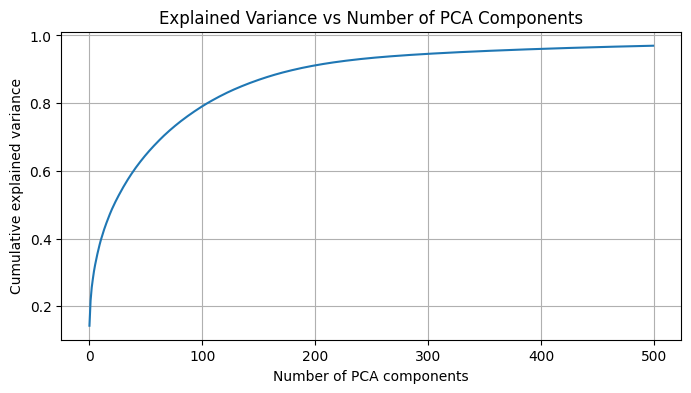

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.976144,-0.210584,2.963215,3.004913,2.955912,0.898777,1.838552,-2.310745,0.083847,0.046694,...,-0.060480,1.473387,-0.808555,0.420197,-0.426358,0.580606,0.068469,0.723649,0.706805,-0.894069
1,-4.734609,1.820231,-3.011337,-0.206981,0.930390,0.776214,0.894732,-0.835282,-1.831491,0.650679,...,-0.206054,-0.038350,0.410777,0.042696,-0.493656,1.304157,0.456087,0.455012,0.609982,0.000642
2,-4.089971,-2.151891,-0.242414,2.772428,0.719885,-1.159385,-1.128813,0.598929,-0.280853,-0.435660,...,0.791789,-0.531549,-0.914467,-0.609036,0.757483,0.353733,-0.302923,-0.279916,-0.826905,0.181967


In [27]:
train_features = df_features.values
val_features = df_features_val.values
top_components = 100
resnet_train_pca_feature, pca_train_resnet = pick_top_feature_pca(train_features, top_components, 500)
# Convert PCA transformed features to DataFrame
df_top_100_feature_pca_resnet_train = pd.DataFrame(resnet_train_pca_feature)
df_top_100_feature_pca_resnet_train.head(3)

resnet_val_pca_feature = pick_top_feature_pca_val_test(pca_train_resnet, val_features, top_components)
df_top_100_feature_pca_resnet_val = pd.DataFrame(resnet_val_pca_feature)
df_top_100_feature_pca_resnet_val.head(3)

In [28]:
Y_train_resnet = df_train['label']
X_train_resnet = resnet_val_pca_feature

In [42]:
Y_val_resnet = df_val['label']
X_val_resnet = resnet_val_pca_feature

Pipeline1

In [10]:
preprocessed_features = preprocess_1(df_train)
preprocessed_features.shape

100%|██████████| 2000/2000 [01:21<00:00, 24.47it/s]


(2000, 200)

In [13]:
with open("codebook.npy", "rb") as f:
	codebook = np.load(f)
preprocessed_features_val = preprocess_1(df_val, codebook=codebook)
preprocessed_features_val.shape

# pipeline1 train: preprocessed_features / pipeline1 val: preprocessed_features_val

100%|██████████| 250/250 [00:12<00:00, 19.27it/s]


(250, 200)

In [17]:
Y_train_pipeline1 = df_train['label']
max = np.max(preprocessed_features, axis=1)
vector_representations_normalized = preprocessed_features / max[:, np.newaxis]
X_train_pipeline1 = vector_representations_normalized

In [18]:
Y_val_pipeline1 = df_val['label']
max_val = np.max(preprocessed_features_val, axis=1)
vector_representations_normalized_val = preprocessed_features_val / max_val[:, np.newaxis]
x_val_pipeline1 = vector_representations_normalized_val

pipeline 2

In [30]:
df_preprocessed_2_train = preprocess_2(df_train)
df_preprocessed_2_train.columns = [f'feature_{i}' for i in range(len(df_preprocessed_2_train.columns))]
print(df_preprocessed_2_train.shape)

df_preprocessed_2_val = preprocess_2(df_val)
df_preprocessed_2_val.columns = [f'feature_{i}' for i in range(len(df_preprocessed_2_val.columns))]
print(df_preprocessed_2_val.shape)

(2000, 63504)
(250, 63504)


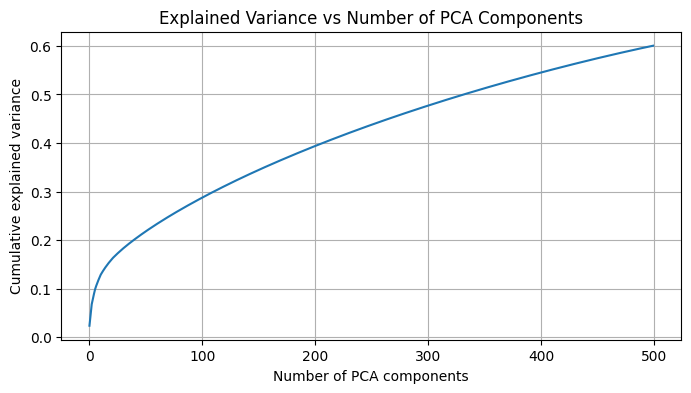

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.736418,0.130757,-1.766228,0.260236,0.356156,1.014717,0.336356,-0.712160,-0.389219,-0.185575,...,-0.136215,0.145844,-0.231679,-0.054590,-0.086379,0.088747,-0.091603,-0.111375,-0.023720,0.143600
1,0.401676,0.690476,1.928689,-0.186043,-1.166595,0.943339,-0.239857,-0.009603,0.188634,0.541961,...,0.232556,-0.115339,-0.029814,0.043420,-0.124619,0.043092,-0.159754,0.050935,0.031474,-0.080787
2,0.667509,-2.050281,-0.696659,-1.042485,-0.344287,-0.785745,0.380179,-0.011720,-0.436944,0.150839,...,-0.137072,-0.168776,0.008544,0.074852,0.176762,-0.042198,0.068975,-0.062427,0.026535,-0.090697


In [32]:
train_features = df_preprocessed_2_train.values
val_features = df_preprocessed_2_val.values
top_components = 200
hog_train_pca_feature, pca_train_hog = pick_top_feature_pca(train_features, top_components, 500)
# Convert PCA transformed features to DataFrame
df_top_100_feature_pca_hog_train = pd.DataFrame(hog_train_pca_feature)
df_top_100_feature_pca_hog_train.head(3)

hog_val_pca_feature = pick_top_feature_pca_val_test(pca_train_hog, val_features, top_components)
df_top_100_feature_pca_hog_val = pd.DataFrame(hog_val_pca_feature)
df_top_100_feature_pca_hog_val.head(3)

In [33]:
# feature normarlization since we only pick up top 200. z score normalization

from sklearn.preprocessing import StandardScaler

def feature_normalization(df_feature):
  scaler = StandardScaler()
  normalized_features = scaler.fit_transform(df_feature.values)
  df_normalized = pd.DataFrame(normalized_features, columns=df_feature.columns)
  return df_normalized

In [34]:
df_top_100_feature_pca_hog_train_normalized = feature_normalization(df_top_100_feature_pca_hog_train)
df_top_100_feature_pca_hog_val_normalized = feature_normalization(df_top_100_feature_pca_hog_val)

In [35]:
Y_train_hog = df_train['label']
X_train_hog = df_top_100_feature_pca_hog_train_normalized.values

In [36]:
Y_val_hog = df_val['label']
X_val_hog = df_top_100_feature_pca_hog_val_normalized.values

In [43]:
print(X_train_pipeline1.shape, X_train_hog.shape, X_train_resnet.shape)
print(x_val_pipeline1.shape, X_val_hog.shape, X_val_resnet.shape)

(2000, 200) (2000, 200) (2000, 100)
(250, 200) (250, 200) (2000, 100)


Combine all three sets of features

In [41]:
Y_train = df_train['label']
Y_val = df_val['label']

X_train = np.hstack([X_train_pipeline1, X_train_hog, X_train_resnet])
X_val = np.hstack([x_val_pipeline1, X_val_hog, X_val_resnet])
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 250 and the array at index 2 has size 2000